In [54]:
'''Implement Variational Autoencoder'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence
from torch.utils.data import Dataset, DataLoader, random_split
import glob
import numpy as np
import os
from torchvision import transforms
import cv2
from tqdm import tqdm
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [55]:
'''NN parameters'''
lr=0.001
bs=64
epochs=20   # For ease in computation, reduced it
device=torch.device('cpu')

In [56]:
'''Implement Dataloader for MNSIT dataset'''
# Transforms, just as before, no need for normalization, messes up with loss function (need binary)
transform = transforms.Compose([transforms.ToTensor()])
# ,
                                # transforms.Normalize(torch.tensor([0.13]),
                                #                      torch.tensor([0.31]))])

# download dataset
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


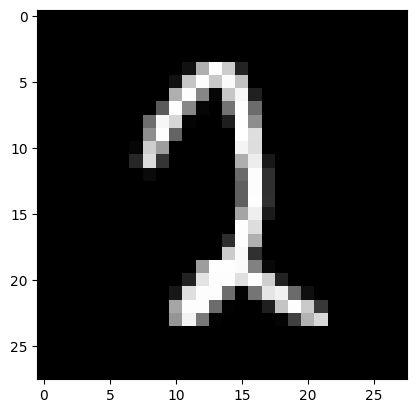

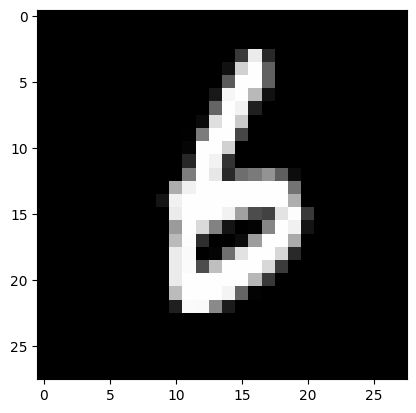

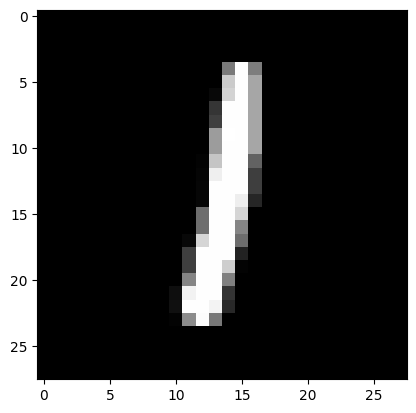

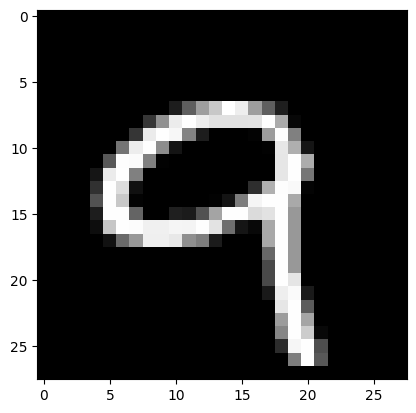

In [57]:
'''Try visualizing mnsit dataset'''
inverse_transform = transforms.Compose([
    # transforms.Normalize(
    #     mean=[-0.13 / 0.31],
    #     std=[1 / 0.31]
    # ),
    transforms.ToPILImage()
])
for x in train_loader:
      for i in range(4):
          img=inverse_transform(x[0][i, :, :, :])
          open_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
          plt.imshow(open_cv)
          plt.show()
      break


In [58]:
'''Weight Initialization for VAE'''
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

In [59]:
class VAE_mnsit(nn.Module):

    def __init__(self, in_dim=784, hidden_dim_1=392, hidden_dim_2=196, device=device):
        super(VAE_mnsit, self).__init__()

        # encoding network
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1,hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2,hidden_dim_2//2),
            nn.ReLU()
            )

        # VAE parametrization
        self.mean = nn.Linear(hidden_dim_2//2, 2)   # This linear layer causes mean to go both +, and -
        self.logvar = nn.Linear(hidden_dim_2//2, 2)

        # Decoding Network
        self.decoder = nn.Sequential(
            nn.Linear(2, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, in_dim),
            nn.Sigmoid()   # BCE loss needs targets b/w 0 and 1, thus Sigmoid
            )

        # Weight initialization
        self.apply(weights_init)

    def encode(self, x):   # To get mean and logarithm of variance
        x = self.encoder(x)
        mean, logvar = self.mean(x), self.logvar(x)
        return mean, logvar

    def decode(self, x):   # To decode
        return self.decoder(x)

    def forward(self, x):    # Forward needs to be implement, pytorch takes care of backward
        mean, log_var = self.encode(x)
        var=torch.exp(0.5 * log_var)   # S.D. is sqrt variance
        e = torch.randn_like(var).to(device)
        z = mean + var*e
        x_tilde = self.decode(z)
        return x_tilde, mean, log_var

In [60]:
'''Function to calculate losses of VAE'''
def loss_calc(x, y, mean, log_var):
    reprojection_loss = nn.functional.binary_cross_entropy(y, x, reduction='sum')     # Observed that MSE loss is bad, anyways the input is 0/1, crossentropy is better
    kl_div = - 0.5 * torch.sum(1+ log_var- log_var.exp() - mean.pow(2))
    return reprojection_loss + kl_div

In [63]:
'''Training pipeline for mnsit dataset'''
model_mnsit=VAE_mnsit().to(device)
optimizer = torch.optim.Adam(model_mnsit.parameters(), lr=lr)

model_mnsit.train()
for epoch in range(epochs):
    tot_loss = 0
    for i, (x, _) in enumerate(train_loader):

        x = x.view(-1, 784).to(device)

        optimizer.zero_grad()

        x_tilde, mean, log_var = model_mnsit(x)

        loss=loss_calc(x, x_tilde, mean, log_var)
        tot_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("Average Loss for {}st epoch is {}".format(epoch+1, tot_loss/(i*batch_size)))

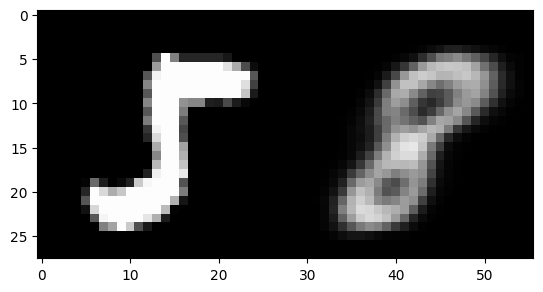

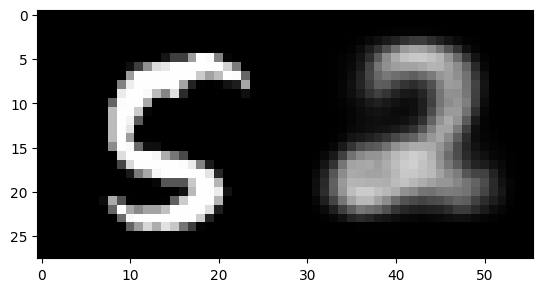

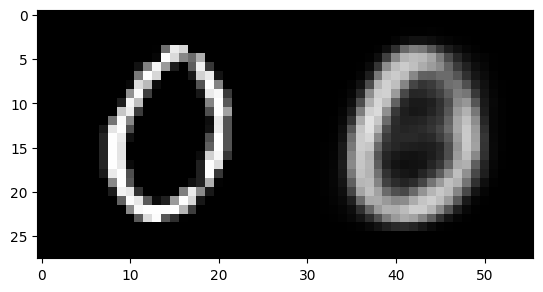

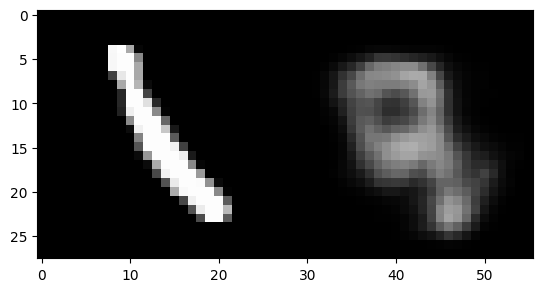

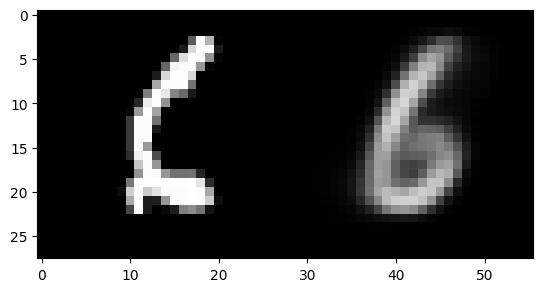

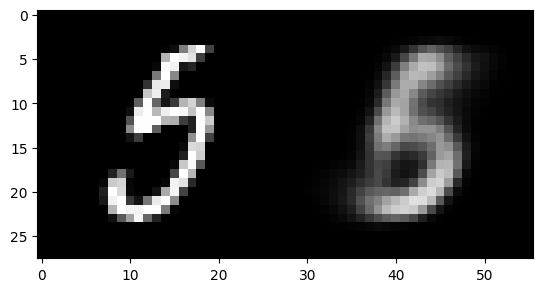

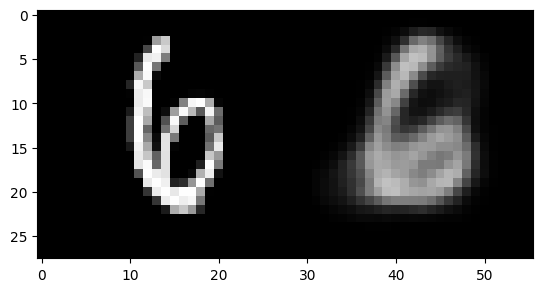

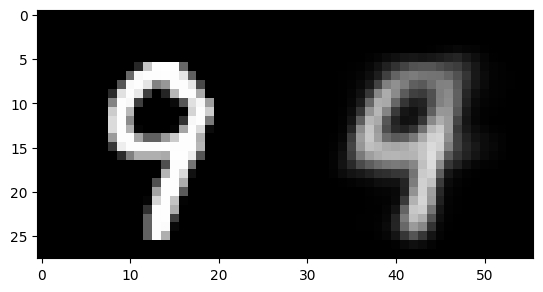

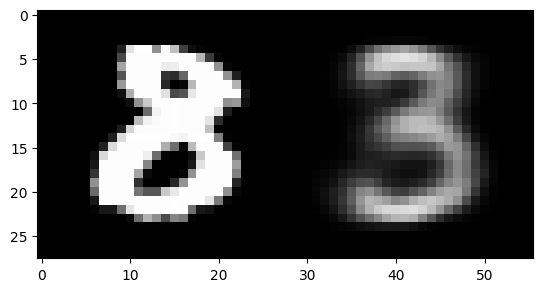

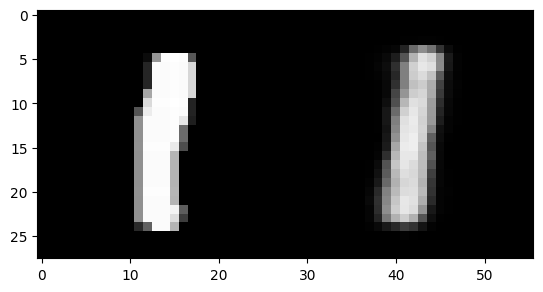

In [15]:
'''Testing, visualization'''
with torch.no_grad():
    for i, (x, num) in enumerate(test_loader):
        x=x.view(-1, 784)
        if i<1:
            x_tilde, mean, log_var =model_mnsit(x.to(device))
            for j in range(10):
                
                image = inverse_transform(x[j, :].view(1, 28, 28))

                open_cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                output_image = inverse_transform(x_tilde[j, :].view(1, 28, 28))
                open_cv_output_image = cv2.cvtColor(np.array(output_image), cv2.COLOR_RGB2BGR)
                plt.imshow(np.concatenate((open_cv_image, open_cv_output_image), axis=1 ))
                plt.show()
            break

**Study results further to see if any intution is valid**

In [16]:
'''Get the mean of all means obtained for particular indexes'''
dict_all={}
dict_var={}
data_points={}
for i in range(10):
    dict_all[i]=[]
    dict_var[i]=[]
    data_points[i]={}
with torch.no_grad():
    for i, (x, num) in enumerate(train_loader):
        x=x.view(-1, 784)
        x_tilde, mean, log_var =model_mnsit(x.to(device))
        for j in range(x.size(0)):
            dict_all[num[j].item()].append(mean[j, :].numpy())
            dict_var[num[j].item()].append(torch.exp(0.5 * log_var[j, :]).numpy())

for key in dict_all.keys():
    data_points[key]['mean']=np.mean(np.array(dict_all[key]), axis=0)
    data_points[key]['covariance']=np.cov(np.array(dict_all[key]), rowvar=False)


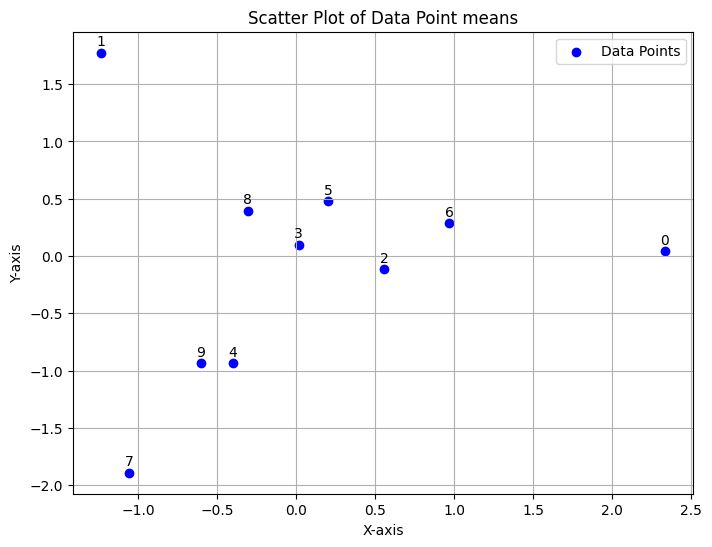

In [17]:
'''Plottig means'''
x_coords, y_coords = [], []
for key in data_points.keys():
    x_coords.append(data_points[key]['mean'][0])
    y_coords.append(data_points[key]['mean'][1])

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, marker='o', color='blue', label='Data Points')

# Annotate points with their indices
for idx, point in data_points.items():
    plt.annotate(str(idx), (point['mean'][0], point['mean'][1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Data Point means')
plt.grid(True)
plt.legend()
plt.show()

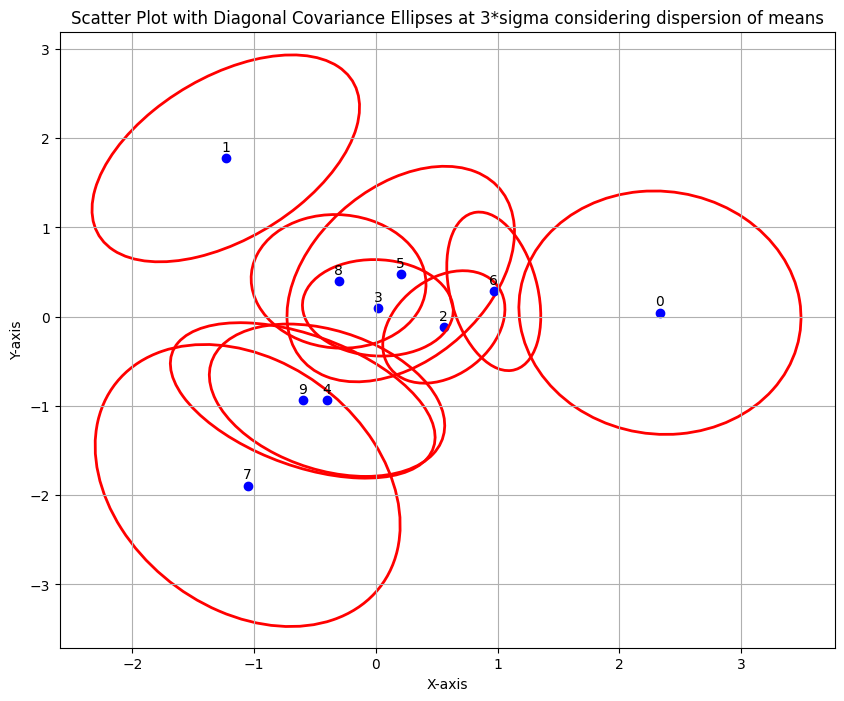

In [18]:
'''Plotting variance with 3 sigma belts'''
plt.figure(figsize=(10, 8))

for idx, point_info in data_points.items():
    mean = point_info['mean']
    covariance = point_info['covariance']

    # Scatter plot for the numbers
    plt.scatter(mean[0], mean[1], marker='o', color='blue', label=f'{idx}')

    # Create ellipse using eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    ellipse = Ellipse(xy=mean, width=np.sqrt(eigenvalues[0]) * 3, height=np.sqrt(eigenvalues[1]) * 3,
                      angle=angle, edgecolor='red', fc='none', lw=2)
    plt.gca().add_patch(ellipse)

    # Annotate points with their indices
    plt.annotate(str(idx), (mean[0], mean[1]), textcoords="offset points", xytext=(0, 5), ha='center')

# Adding labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Diagonal Covariance Ellipses at 3*sigma considering dispersion of means')
plt.grid(True)
plt.show()


 **Stretch: VAE implementation for real cat and dog images using convolutional NNs, gave poor results**
 :

In [44]:
'''Implement Dataset class for Cat Dog dataset, which must have a len, and getitem function'''
class VAEdataset_train(Dataset):
    def __init__(self, transform=None):
        self.imgs_path = "PetImages/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            print(class_path)
            class_name = class_path.split("\\")[-1]     # Dog or cat
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"Dog" : 0, "Cat": 1}
        self.img_dim = (256, 256)
        self.transform=transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        try:
            X = cv2.resize(img, self.img_dim)
        except:
            X=np.zeros((self.img_dim[0], self.img_dim[1], 3)).astype('uint8')
        class_id = self.class_map[class_name]
        class_id = torch.tensor([class_id])
        if self.transform:
            X=self.transform(X)
        return X


In [45]:
'''Create Dataloaders for Cat Dog dataset, might be too slow due to GPU '''

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]),
                                                     torch.tensor([0.229, 0.224, 0.225]))]) # Got this value from discussions on ImageNet dataset

all_data=VAEdataset_train(transform=transform)
tot_len=all_data.__len__()
train_len=int(0.9*tot_len)
test_len=tot_len-train_len
train_data, test_data = random_split(all_data, [train_len, test_len])
train_loader=DataLoader(train_data, batch_size=bs, shuffle=True)
test_loader=DataLoader(test_data, batch_size=bs, shuffle=True)


PetImages\Cat
PetImages\Dog


In [46]:
'''VAE for cat dog dataset Architecture'''
class VAE(nn.Module):
    def __init__(self, input_dim, output_dim, dim, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, 2*dim, 4, 2, 1),
            nn.BatchNorm2d(2*dim),
            nn.ReLU(True),
            nn.Conv2d(2*dim, 2*dim, 5, 1, 0),
            nn.BatchNorm2d(2*dim),
            nn.ReLU(True),
            nn.Conv2d(2*dim, z_dim * 2, 3, 1, 0),
            nn.BatchNorm2d(z_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, dim, 3, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, 2*dim, 5, 1, 0),
            nn.BatchNorm2d(2*dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(2*dim, 2*dim, 4, 2, 1),
            nn.BatchNorm2d(2*dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(2*dim, output_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def forward(self, x):
        mu, logvar = self.encoder(x).chunk(2, dim=1)   # Splits into two
        q_z_x = Normal(mu, logvar.mul(.5).exp())
        p_z = Normal(torch.zeros_like(mu), torch.ones_like(logvar))
        kl_div = kl_divergence(q_z_x, p_z).sum(1).mean()

        x_tilde = self.decoder(q_z_x.rsample())    # resample is just a part of the reparaetrization trick, can backpropagate from this
        return x_tilde, kl_div

**Directly move to next block, that uses trained weights**

In [50]:
'''Training pipeline for cat dog dataset'''
'''Model, optimizer'''
model=VAE(3, 3, 32, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if os.path.isfile('model.pth'):
    
    model.load_state_dict(torch.load('model.pth', map_location=device))
    optimizer.load_state_dict(torch.load('optim.pth', map_location=device))

    training_history=torch.load('training_history.pth', map_location=device)

else:
    training_history={'last_ep': 0, 'train_loss': [], 'val_loss': [], 'best_loss': 100.0}

start_ep=training_history['last_ep']

'''Training'''
train_loss=[]
test_loss=[]
for epoch in range(start_ep, 1000):
    optimizer.zero_grad()
    train_loss_=[]
    test_loss_=[]
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, x in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            x_tilde, kl_div =model(x.to(device))
            reconst_loss=F.mse_loss(x_tilde.to(device), x.to(device))
            loss=reconst_loss.to(device)+kl_div
            train_loss_.append(loss.detach().cpu().numpy())    # I think this resolved the slow training issue
            loss.backward()
            optimizer.step()
    training_history['train_loss'].append(np.mean(np.array(train_loss_)))
    training_history['last_ep']=i
    print('train loss for epoch {}: '.format(epoch), np.mean(np.array(train_loss_)))

    '''Eval'''
    if epoch%5==0:
        with torch.no_grad():
            for x in test_loader:
                x_tilde, kl_div =model(x.to(device))
                reconst_loss=F.mse_loss(x_tilde.to(device), x.to(device))
                loss_test=(reconst_loss+kl_div).to(device)
                test_loss_.append(loss_test.detach().cpu().numpy())
        training_history['val_loss'].append(np.mean(np.array(test_loss_)))
        print('test loss for epoch {}: '.format(epoch), np.mean(np.array(test_loss_)))

        if np.mean(np.array(test_loss_))<0.99*training_history['best_loss']:
            torch.save(model.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optim.pth')
            training_history['best_loss']=np.mean(np.array(test_loss_))
            torch.save(training_history, 'training_history.pth')

        else:
            continue



Looks like a semantic map, not the full image, implying that training is not done properly, however the network is trying to learn something. Just need some improvements

0


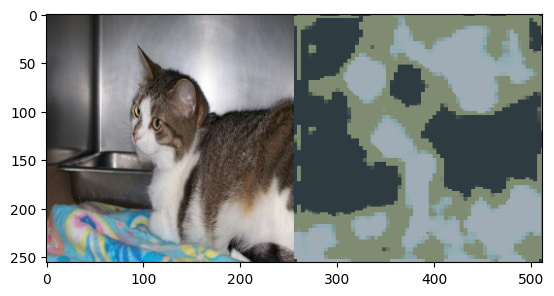

1


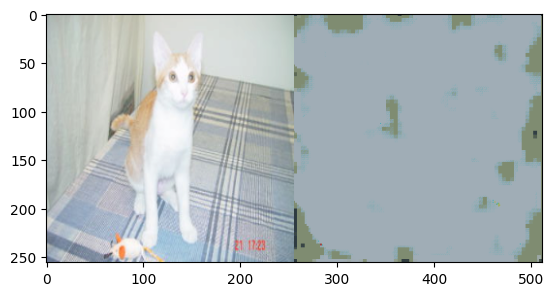

2


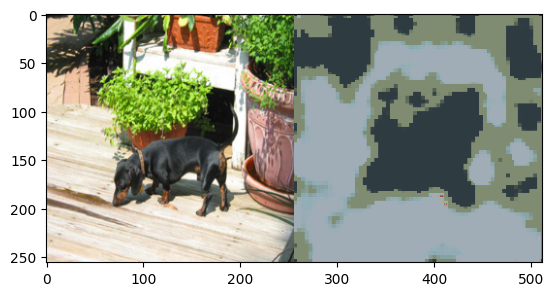

3


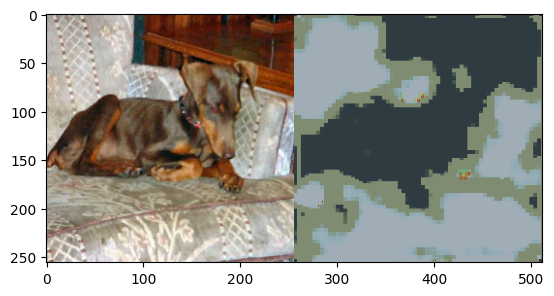

4


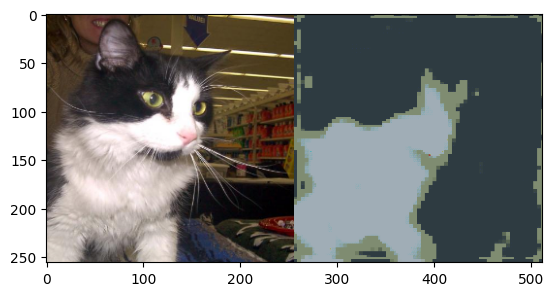

In [49]:
'''Testing Pipeline for  cat dog dataset'''
model=VAE(3, 3, 32, 10).to(device)
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))
training_history=torch.load('training_history.pth')

'''Inverse transform to visualize, the values here are standard for imagemnet'''
inverse_transform = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                transforms.ToPILImage()
                               ])


with torch.no_grad():
    for i, x in enumerate(train_loader):
        if i<1:
            x_tilde, _ =model(x.to(device))
            for j in range(5):
                print(j)
                reversed_image_o = inverse_transform(x[j, :, :, :].squeeze())
                open_cv_image_o = cv2.cvtColor(np.array(reversed_image_o), cv2.COLOR_RGB2BGR)

                reversed_image = inverse_transform(x_tilde[j, :, :, :].squeeze())
                open_cv_image = cv2.cvtColor(np.array(reversed_image), cv2.COLOR_RGB2BGR)
                plt.imshow(np.concatenate((open_cv_image_o, open_cv_image), axis=1 ))
                plt.show()
            break
